https://python.langchain.com/docs/tutorials/rag/

In [1]:
%pip install --quiet --upgrade langchain-text-splitters langchain-community langgraph langchain-google-vertexai langchain-community faiss-cpu beautifulsoup4

Note: you may need to restart the kernel to use updated packages.


In [20]:
import os
from dotenv import load_dotenv
import csv
import bs4
import faiss
from langchain.chat_models import init_chat_model
from langchain_google_vertexai import VertexAIEmbeddings
from langchain_community.docstore.in_memory import InMemoryDocstore
from langchain_community.vectorstores import FAISS
from langchain import hub
from langchain_core.documents import Document
from langchain_core.messages import SystemMessage
from langchain_core.tools import tool
from langchain_community.document_loaders import WebBaseLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langgraph.graph import START, StateGraph, MessagesState, END
from langgraph.prebuilt import ToolNode, tools_condition, create_react_agent
from langgraph.checkpoint.memory import MemorySaver
from typing_extensions import List, TypedDict
from IPython.display import Image, display

In [2]:
load_dotenv()
assert "LANGSMITH_TRACING" in os.environ, "Please set the LANGSMITH_TRACING environment variable."
assert "LANGSMITH_API_KEY" in os.environ, "Please set the LANGSMITH_API_KEY environment variable."
assert "MONGODB_COLLECTION" in os.environ, "Please set the MONGODB_COLLECTION environment variable."
assert "ATLAS_VECTOR_SEARCH_INDEX_NAME" in os.environ, "Please set the ATLAS_VECTOR_SEARCH_INDEX_NAME environment variable."
MONGODB_COLLECTION = os.getenv('MONGODB_COLLECTION')
ATLAS_VECTOR_SEARCH_INDEX_NAME = os.getenv('ATLAS_VECTOR_SEARCH_INDEX_NAME')

In [3]:
embeddings = VertexAIEmbeddings(model="text-embedding-004")

In [4]:
index = faiss.IndexFlatL2(len(embeddings.embed_query("hello world")))

vector_store = FAISS(
    embedding_function=embeddings,
    index=index,
    docstore=InMemoryDocstore(),
    index_to_docstore_id={},
)

In [7]:
url_list = []
with open('.//..//..//files//20250207-posts_list-red.csv', 'r') as csvfile:
    spamreader = csv.reader(csvfile)
    for row in spamreader:
        url = str(row[0]).replace("http","https")
        url_list.append(url)
print(url_list[0])

https://www.reflexoesdofilosofo.blog.br/2025/02/o-problema-de-parmenides.html


In [8]:
urls = [
    "https://www.reflexoesdofilosofo.blog.br/2024/08/a-terceira-margem-do-rio.html",
    "https://www.reflexoesdofilosofo.blog.br/2024/09/uma-teoria-da-mente.html",
    "https://www.reflexoesdofilosofo.blog.br/2025/02/o-problema-de-parmenides.html",
]

In [9]:
loader = WebBaseLoader(
    web_paths=(url_list),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("post hentry uncustomized-post-template", "post-title entry-title", "post-header")
        )
    ),
)
docs = loader.load()
len(docs)

435

In [10]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
all_splits = text_splitter.split_documents(docs)
len(all_splits)

2675

In [11]:
_ = vector_store.add_documents(documents=all_splits)

In [21]:
llm = init_chat_model("gemini-2.0-flash-001", model_provider="google_vertexai")

In [12]:
@tool(response_format="content_and_artifact")
def retrieve(query: str):
    """Retrieve information related to a query."""
    retrieved_docs = vector_store.similarity_search(query, k=2)
    serialized = "\n\n".join(
        (f"Source: {doc.metadata}\n" f"Content: {doc.page_content}")
        for doc in retrieved_docs
    )
    return serialized, retrieved_docs

In [13]:
# Step 1: Generate an AIMessage that may include a tool-call to be sent.
def query_or_respond(state: MessagesState):
    """Generate tool call for retrieval or respond."""
    llm_with_tools = llm.bind_tools([retrieve])
    response = llm_with_tools.invoke(state["messages"])
    # MessagesState appends messages to state instead of overwriting
    return {"messages": [response]}

In [14]:
# Step 3: Generate a response using the retrieved content.
def generate(state: MessagesState):
    """Generate answer."""
    # Get generated ToolMessages
    recent_tool_messages = []
    for message in reversed(state["messages"]):
        if message.type == "tool":
            recent_tool_messages.append(message)
        else:
            break
    tool_messages = recent_tool_messages[::-1]

    # Format into prompt
    docs_content = "\n\n".join(doc.content for doc in tool_messages)
    system_message_content = (
        "You are an assistant for question-answering tasks. "
        "Use the following pieces of retrieved context to answer "
        "the question. If you don't know the answer, say that you "
        "don't know. Use three sentences maximum and keep the "
        "answer concise."
        "\n\n"
        f"{docs_content}"
    )
    conversation_messages = [
        message
        for message in state["messages"]
        if message.type in ("human", "system")
        or (message.type == "ai" and not message.tool_calls)
    ]
    prompt = [SystemMessage(system_message_content)] + conversation_messages

    # Run
    response = llm.invoke(prompt)
    return {"messages": [response]}

In [16]:
tools = ToolNode([retrieve])

In [17]:
graph_builder = StateGraph(MessagesState)
graph_builder.add_node(query_or_respond)
graph_builder.add_node(tools)
graph_builder.add_node(generate)

graph_builder.set_entry_point("query_or_respond")
graph_builder.add_conditional_edges(
    "query_or_respond",
    tools_condition,
    {END: END, "tools": "tools"},
)
graph_builder.add_edge("tools", "generate")
graph_builder.add_edge("generate", END)

graph = graph_builder.compile()

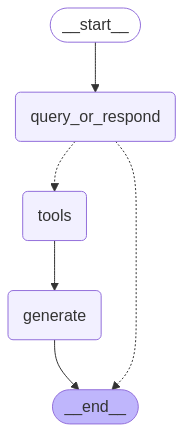

In [18]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [22]:
input_message = "Hello"

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Hello
================================== Ai Message ==================================

Hello! How can I help you today?


In [23]:
input_message = "me fale sobre a mente"

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

me fale sobre a mente
================================== Ai Message ==================================
Tool Calls:
  retrieve (ea3cdbb9-2f92-4347-a25f-0b958b9a9031)
 Call ID: ea3cdbb9-2f92-4347-a25f-0b958b9a9031
  Args:
    query: mente
================================= Tool Message =================================
Name: retrieve

Source: {'source': 'https://www.reflexoesdofilosofo.blog.br/2016/06/consideracoes-gerais-sobre-filosofia-da.html'}
Content: Partiremos
da nossa definição de mente como um substrato imaterial que acompanha nossa
atividade física corporal e cerebral. Nesse sentido, não somos materialistas,
ou seja, a mente não se resume à matéria, ela é um algo mais. Não queremos
aproximá-la do conceito de alma como algo que era, foi e sempre será
independente do corpo. Acreditamos em algum tipo de ligação corpo-mente. Nesse
sentido, não somos espiritualistas, ou seja, a mente não se confunde com

In [24]:
memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)

# Specify an ID for the thread
config = {"configurable": {"thread_id": "abc123"}}

In [25]:
input_message = "me fale sobre a mente"

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
    config=config,
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

me fale sobre a mente
================================== Ai Message ==================================
Tool Calls:
  retrieve (89e2b432-ed79-4f52-8840-3bd8334778a6)
 Call ID: 89e2b432-ed79-4f52-8840-3bd8334778a6
  Args:
    query: mente humana
================================= Tool Message =================================
Name: retrieve

Source: {'source': 'https://www.reflexoesdofilosofo.blog.br/2016/06/consideracoes-gerais-sobre-filosofia-da.html'}
Content: A
mente, então, é algo de tamanho muito pequeno, algo como um efeito do corpo e
suas sensações e da memória, do intelecto e uma suposta racionalidade. A mente
é o lugar onde os sentimentos florescem, para onde as emoções convergem, a
mente é uma foto instantânea de algo que nos representa nesse momento. Ela
aparece e só sabemos dela porque refletimos. Tudo fica no corpo, é o corpo
físico e material que sente, que armazena conhecimento, que guarda má

In [37]:
input_message = "consciência subjetiva"

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}, {"role": "system", "content": "sempre informe a fonte"}]},
    stream_mode="values",
    config=config,
):
    step["messages"][-1].pretty_print()

================================ System Message ================================

sempre informe a fonte
================================== Ai Message ==================================
Tool Calls:
  retrieve (7a2c58cd-4704-4c9f-94fa-329bb8a7d1fe)
 Call ID: 7a2c58cd-4704-4c9f-94fa-329bb8a7d1fe
  Args:
    query: consciencia subjetiva
================================= Tool Message =================================
Name: retrieve

Source: {'source': 'https://www.reflexoesdofilosofo.blog.br/2016/12/movimento-filosofico.html'}
Content: A subjetividade se move na
percepção do mundo, constituindo-o. Se o ego é um agora da percepção, esse
agora abrange um passado como a intencionalidade daquele momento e um futuro
que se abre para a vivência que acompanha o fenômeno. Cada vivência subjetiva delimita o objeto e o mundo e o ego passa e fica, como o outro polo. Esse encontro da subjetividade com o mundo fenomenológico é um aprofundamento para além das formas da sensibilidade, mas é contrário à p

In [27]:
agent_executor = create_react_agent(llm, [retrieve], checkpointer=memory)

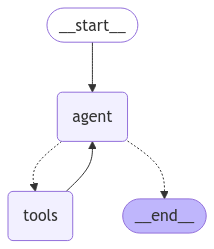

In [28]:
display(Image(agent_executor.get_graph().draw_mermaid_png()))

In [31]:
config = {"configurable": {"thread_id": "def234"}}

input_message = (
    "me fale sobre a mente\n\n"
    "depois aprofunde algum aspecto"
)

for event in agent_executor.stream(
    {"messages": [{"role": "user", "content": input_message}, {"role": "system", "content": "sempre informe a fonte"}]},
    stream_mode="values",
    config=config,
):
    event["messages"][-1].pretty_print()

================================ System Message ================================

sempre informe a fonte
================================== Ai Message ==================================

A mente é um conjunto complexo de capacidades cognitivas que nos permite perceber, pensar, sentir, aprender, lembrar, tomar decisões e interagir com o mundo ao nosso redor. Ela abrange processos conscientes e inconscientes, e é influenciada por fatores biológicos, psicológicos e sociais. A mente é frequentemente associada ao cérebro, mas a relação exata entre os dois ainda é um tema de debate.

Aprofundando um aspecto: **a relação entre mente e corpo.**

Essa relação tem sido objeto de reflexão filosófica e científica por séculos. Uma das questões centrais é se a mente é uma entidade separada do corpo (dualismo) ou se é um produto da atividade física do cérebro (fisicalismo ou materialismo).

*   **Dualismo:** Argumenta que a mente e o corpo são duas substâncias distintas, com propriedades diferentes. 

In [34]:
config = {"configurable": {"thread_id": "def234"}}

input_message = (
    "me fale sobre Searle no que há nos textos e em qual texto achou \n\n"
)

for event in agent_executor.stream(
    {"messages": [{"role": "user", "content": input_message}, {"role": "system", "content": "sempre informe a fonte"}]},
    stream_mode="values",
    config=config,
):
    event["messages"][-1].pretty_print()

================================ System Message ================================

sempre informe a fonte
================================== Ai Message ==================================

Não há menção a Searle nos textos fornecidos. Portanto, não posso fornecer informações sobre ele com base nesses textos.


In [12]:
# Define prompt for question-answering
prompt = hub.pull("rlm/rag-prompt")

In [13]:
# Define state for application
class State(TypedDict):
    question: str
    context: List[Document]
    answer: str


# Define application steps
def retrieve(state: State):
    retrieved_docs = vector_store.similarity_search(state["question"])
    return {"context": retrieved_docs}


def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}

In [14]:
# Compile application and test
graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()

In [16]:
response = graph.invoke({"question": "me fale sobre a mente"})
print(response["answer"])

A teoria da mente está relacionada à filosofia da mente, que questiona a natureza da consciência e do mental. Alguns materialistas tratam o mental como algo puramente cerebral, mas a consciência é vista por outros como um fenômeno irredutível. A neurociência busca elucidar a consciência através da investigação científica do cérebro.

